In [1]:
#import libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import random

import matplotlib
from matplotlib import pyplot as plt 

import seaborn as sns
import pickle as pkl
import pandas as pd
import pylab as plt
import matplotlib.ticker as ticker


params = {'font.size' : 15,
          'axes.labelsize': 15,               # -> axis labels
          'legend.fontsize': 15,              # -> legends
          'font.family': 'sans-serif',
          'font.sans-serif': "Comic Sans MS",
          'font.weight': 'bold',
          "axes.labelweight": "bold",
          "axes.titlesize": "medium",
          "axes.titleweight": "bold",
          }
plt.rcParams.update(params) 


#local files being imported
import sys
import os
sys.path.insert(0, '../src')
import platform_opt
from players import *
import sims
import sims_copy
from statistics import variance

sns.set_style("ticks", {"xtick.major.size": 10, "ytick.major.size": 10})
mk = sns.color_palette('mako', n_colors=4)



In [2]:
# SIMULATION PARAMETERS AGNOSTIC TO DATA
T = 10                 # max number of timesteps
M = 10000            # size of unit mass
delta_low = 0.5
delta_high= 1.2
num_trials = 25


#load parameters from dataset
dataset_name = 'facebook'
dire = '../'+dataset_name+'/figures/'
dire_data = '../same_init_runs/'+dataset_name+'/'
if not os.path.exists(dire):
    os.makedirs(dire)
if not os.path.exists(dire_data):
    os.makedirs(dire_data)
pi,beta_dist,P,v,c,q = sims.get_params(dataset_name)

Don't run this next cell if you already know what the theta params are

In [3]:
#how to show articles at timestep 1
#epsilon for additive constraints (difference in expected exposure bounded by epsilon)
epsilon = 0.25
#params for ratio constraints
#delta_low = 0.7
#delta_high = 1.2
#exposure_e is a linear constraint that theta_A, theta_B \in [exposure_e, 1-exposure_e]
exposure_e = 0.

#constrained with exposure equality
#theta_additive = platform_opt.opt('additive',pi, q, T, c,v,beta_dist,epsilon=epsilon, exposure_e=exposure_e) 
#unconstrained to optimize clicks
theta_opt = platform_opt.opt('unconstrained', pi, q, T, c,v,beta_dist, exposure_e = exposure_e) 
#constrained with exposure equality
theta_ratio = platform_opt.opt('ratio',pi, q, T, c,v,beta_dist,delta_low=delta_low, \
                               delta_high=delta_high, exposure_e=exposure_e) 
theta_half = {1: 0.5, -1: 0.5}
theta_proportional = pi

#print(theta_additive)
#print(theta_opt)
print("Theta fair")
print(theta_ratio)

Theta fair
{-1: 0.03277709944542968, 1: 0.9999999997848062}


In [4]:
# #since the optimization in the following cell only needs to be run once per set of parameters

#theta_additive = {-1: 0.049999999961021876, 1: 0.22694132946782486}
theta_half = {1: 0.5, -1: 0.5}
theta_opt = {-1: 2.988115162028853e-11, 1: 0.9999999999549978}
theta_ratio = {-1: 0.03277709944542968, 1: 0.9999999997848062}
theta_proprtional = pi



In [4]:
trials_to_run = {'random':theta_half, 'unconstrained':theta_opt, 'fair exposure':theta_ratio, 'proportional exposure':theta_proportional} #'additive':theta_additive

given number of trials and which types of interventions we want to test, returns the outputs 

In [5]:
trials = [sims.runModel_samepop(T, pi, M, P, beta_dist, v,c,q, trials_to_run) for ix in range(num_trials)]
avg = sims.average_dfs(trials) #dict of dataframes

new way of saving the trials.  trials is a list of dicts of dataframes; dicts indexed by theta_type, and dataframes have number of players, shown, click, and share

In [6]:
sims.saveRuns(trials, dire_data+'trials.pkl')
sims.saveRuns(avg, dire_data+'averages.pkl')

new way to unpickle data

In [8]:
trials = sims.loadRuns(dire_data+'trials.pkl') #path not right
avg = sims.loadRuns(dire_data+'averages.pkl')


In [7]:
#average intergroup exposure and share
#normalized by number of impressions/clicks in model
#higher is better here
#doesn't do anything functionally; just gives some insight, so don't feel like you have to run this.

print('Intergroup exposure')
for theta_type in trials_to_run.keys():
    print(theta_type)
    print(np.sum([avg[theta_type]['shown'][i][(1,-1)] for i in range(len(avg[theta_type]['shown'].index))]))
    print(np.sum([avg[theta_type]['shown'][i][(-1,1)] for i in range(len(avg[theta_type]['shown'].index))]))
    
print('\nIntergroup shares')
for theta_type in trials_to_run.keys():
    print(theta_type)
    print(np.sum([avg[theta_type]['share'][i][(1,-1)] for i in range(len(avg[theta_type]['share'].index))]))
    print(np.sum([avg[theta_type]['share'][i][(-1,1)] for i in range(len(avg[theta_type]['share'].index))]))
    


Intergroup exposure
random
3035.64
3019.8000000000006
unconstrained
972.8399999999999
782.4400000000002
fair exposure
969.2
908.52
proportional exposure
3036.72
3031.0

Intergroup shares
random
210.56
171.47999999999996
unconstrained
90.72
165.92000000000004
fair exposure
85.52
163.20000000000002
proportional exposure
217.36
165.0


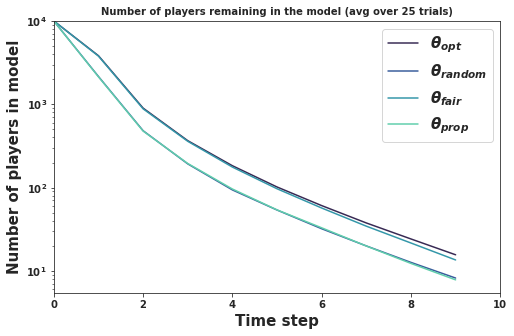

In [8]:
num_trials = len(trials)

avg_opt = avg['unconstrained']
avg_half = avg['random']
avg_ratio = avg['fair exposure']
avg_prop = avg['proportional exposure']
# avg_additive = avg['additive']

ao = max(avg_opt['players_list'])
ah = max(avg_half['players_list'])
ar = max(avg_ratio['players_list'])
ap = max(avg_prop['players_list'])

np.log(max(ao, max(ah, max(ar, ap))))

# fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(8, 5))


sns.lineplot(data=avg_opt, x=range(T), y='players_list', label='$\\theta_{opt}$', color=mk[0])
sns.lineplot(data=avg_half, x=range(T), y='players_list', label='$\\theta_{random}$', color=mk[1])
sns.lineplot(data=avg_ratio, x=range(T), y='players_list', label='$\\theta_{fair}$', color=mk[2])
sns.lineplot(data=avg_prop, x=range(T), y='players_list', label='$\\theta_{prop}$', color=mk[3])
#sns.lineplot(data=avg_additive, x=range(T), y='players_list',label='$\\theta_{add}$',color=mk[3])
plt.yscale('log')
plt.xlim((0,T))
plt.ylim((0, M))
ax.set(xlabel='Time step', ylabel='Number of players in model', title = "Number of players remaining in the "+\
       "model (avg over %i trials)" % (num_trials))

plt.savefig(dire+"_num_players_in_model.pdf")
plt.show()

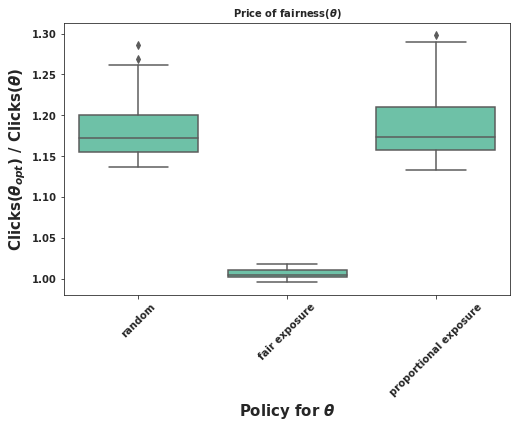

In [9]:
pof = {}
for theta_type in trials_to_run.keys():
    pof[theta_type] = [(trials[i]['unconstrained']['players_list'].sum() / trials[i][theta_type]['players_list'].sum())\
                       for i in range(num_trials)]

del(pof['unconstrained'])
boxplot_pof = pd.DataFrame(data=pof)
boxplot_pof.rename(columns={"random": "randomized policy", "fair exposure": "$\\theta_{fair}$", "proportional exposure":"$\\theta = \\pi$"})

# fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(x="variable", y="value", data=pd.melt(boxplot_pof), color=mk[3])
ax.set(xlabel='Policy for $\\theta$', ylabel="Clicks($\\theta_{opt}$) / Clicks($\\theta$)",\
       title='Price of fairness($\\theta$)')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
plt.savefig(dire+dataset_name+"_pof_boxplot.pdf")

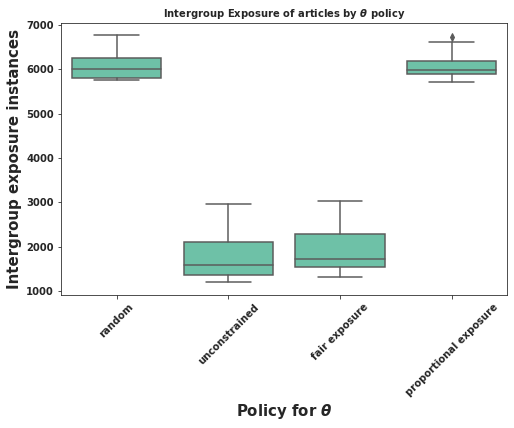

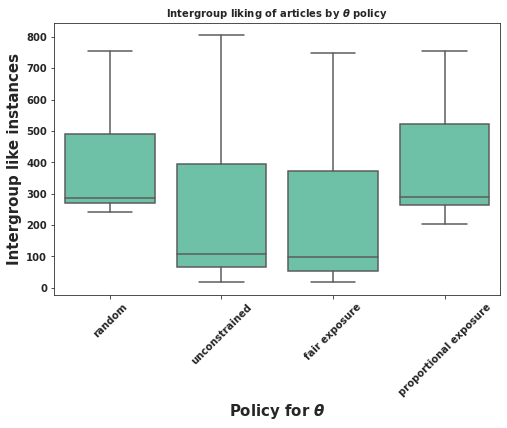

In [10]:
ig_shares = {}
ig_shown = {}
for theta_type in trials_to_run.keys():
    ig_shares[theta_type] = []
    ig_shown[theta_type] = []
    for i in range(num_trials):
        ig_shown[theta_type].append(np.sum([trials[i][theta_type]['shown'][j][(1,-1)] \
                                        + trials[i][theta_type]['shown'][j][(-1,1)] for j in range(T)]))
        ig_shares[theta_type].append(np.sum([trials[i][theta_type]['share'][j][(1,-1)] \
                                        + trials[i][theta_type]['share'][j][(-1,1)] for j in range(T)]))
    
boxplot_shown = pd.DataFrame(data=ig_shown)
boxplot_share = pd.DataFrame(data=ig_shares)
        
# plot data
# fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(x="variable", y="value", data=pd.melt(boxplot_shown), color=mk[3])
ax.set(xlabel='Policy for $\\theta$',title='Intergroup Exposure of articles by $\\theta$ policy')
ax.set(ylabel='Intergroup exposure instances')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
plt.savefig(dire+"intergroup_exposure_boxplot.pdf")

fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(x="variable", y="value", data=pd.melt(boxplot_share), color=mk[3])
ax.set(xlabel='Policy for $\\theta$', ylabel="Intergroup like instances",\
       title='Intergroup liking of articles by $\\theta$ policy')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
plt.savefig(dire+"intergroup_likes_boxplot.pdf")

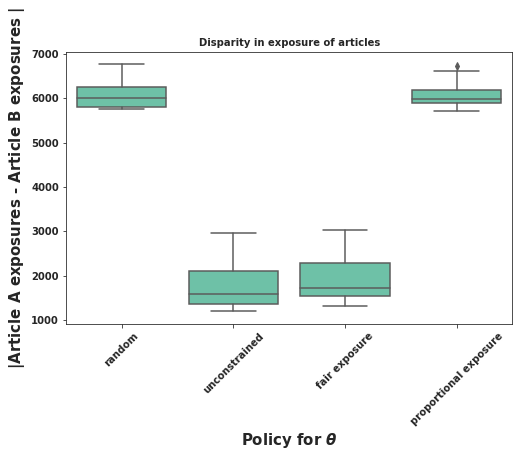

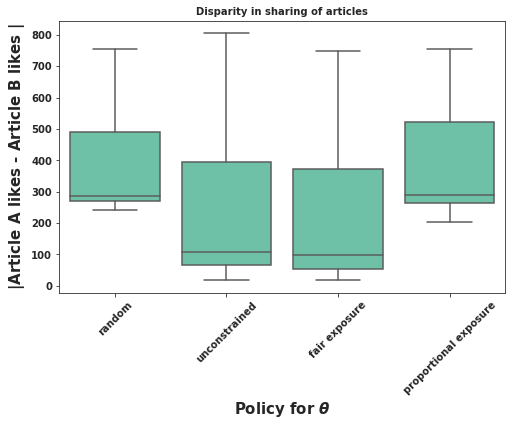

In [11]:
ig_shares = {}
ig_shown = {}
for theta_type in trials_to_run.keys():
    ig_shares[theta_type] = []
    ig_shown[theta_type] = []
    for i in range(num_trials):
        ig_shown[theta_type].append(np.abs(np.sum([trials[i][theta_type]['shown'][j][(1,-1)] \
                                        - trials[i][theta_type]['shown'][j][(-1,1)] for j in range(T)])))
        ig_shares[theta_type].append(np.abs(np.sum([trials[i][theta_type]['share'][j][(1,-1)] \
                                        - trials[i][theta_type]['share'][j][(-1,1)] for j in range(T)])))
    
        
# plot data
# fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(x="variable", y="value", data=pd.melt(boxplot_shown), color=mk[3])
ax.set(xlabel='Policy for $\\theta$', ylabel="$|$Article A exposures - Article B exposures $|$",\
       title='Disparity in exposure of articles')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
plt.savefig(dire+ dataset_name + "_dis_exposure_boxplot.pdf")

fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(x="variable", y="value", data=pd.melt(boxplot_share), color=mk[3])
ax.set(xlabel='Policy for $\\theta$', ylabel="$|$Article A likes - Article B likes $|$",\
       title='Disparity in sharing of articles')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
plt.savefig(dire + dataset_name +"_dis_likes_boxplot.pdf")

### Set of experiments to understand impact of threshold epsilon.

In [16]:
theta_A = {}
theta_B = {}
for exp in [0., 0.01, 0.05, 0.1, 0.15, 0.2]:
    theta_fair = platform_opt.opt('ratio',pi, q, T, c,v,beta_dist,delta_low = delta_low,\
                                  delta_high=delta_high, exposure_e=exp) #constrained with exposure equality 
    theta_A[exp] = theta_fair[1]
    theta_B[exp] = theta_fair[-1]
    print((theta_fair, exp))
    
    
list_A = sorted(theta_A.items()) # sorted by key, return a list of tuples
list_B = sorted(theta_B.items()) # sorted by key, return a list of tuples

KeyboardInterrupt: 

[(0.0, 1.0), (0.01, 0.9901787752533013), (0.05, 0.95), (0.1, 0.9000000000000001), (0.15, 0.8500000000000001), (0.2, 0.7848651856725999)]


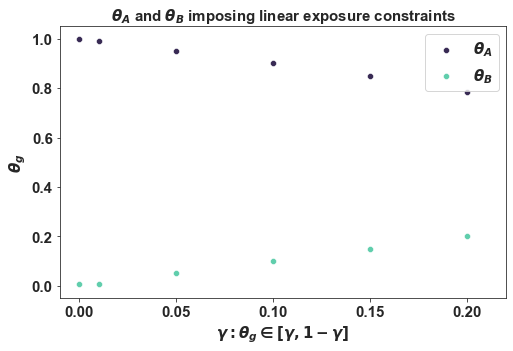

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))
eps_A, thetaA = zip(*list_A) # unpack a list of pairs into two tuples
eps_B, thetaB = zip(*list_B) # unpack a list of pairs into two tuples

print(list_A)

sns.scatterplot(x=eps_A, y=thetaA, color=mk[0])
sns.scatterplot(x=eps_B, y=thetaB, color=mk[3])
ax.set(xlabel='$\\gamma : \\theta_g \\in [\\gamma, 1-\\gamma]$', ylabel='$\\theta_g$',\
       xlim=(-0.01,0.22), ylim=(-0.05,1.05))
ax.set(title='$\\theta_A$ and $\\theta_B$ imposing linear exposure constraints')
ax.legend(['$\\theta_A$', '$\\theta_B$'])
plt.savefig(dire+dataset_name +"_linear_exposure_constraints.png")
plt.show()

In [16]:
sims.saveRuns((list_A, list_B), dire_data+dataset_name+'_vary_linear_exposure.pkl')

In [1]:
list_A, list_B = sims.loadRuns(dire_data+dataset_nane+'_vary_linear_exposure.pkl')

NameError: name 'sims' is not defined

### Experiment with ratio constraint parameters

In [13]:
theta_A = {}
theta_B = {}
exposure_e = 0.05
delta_low_list = [0.6, 0.7, 0.8, 0.9, 0.95]
delta_high_list = [1.001,1.01, 1.05, 1.1, 1.2]
for delta_low in delta_low_list:
    for delta_high in delta_high_list:
        print((delta_low,delta_high))
        theta_ratio = platform_opt.opt('ratio',pi, q, T, c,v,beta_dist,delta_low = delta_low,\
                                       delta_high=delta_high,exposure_e=0.01)
        theta_A[(delta_low, delta_high)] = theta_ratio[1]
        theta_B[(delta_low, delta_high)] = theta_ratio[-1]
    
list_A = sorted(theta_A.items()) # sorted by key, return a list of tuples
hold_A, thetaA = zip(*list_A) # unpack a list of pairs into two tuples
delta_low_A, delta_high_A = zip(*hold_A)

list_B = sorted(theta_B.items()) # sorted by key, return a list of tuples
hold_B, thetaB = zip(*list_B) # unpack a list of pairs into two tuples
delta_low_B, delta_high_B = zip(*hold_B)



(0.6, 1.001)
(0.6, 1.01)
(0.6, 1.05)
(0.6, 1.1)
(0.6, 1.2)
(0.7, 1.001)
(0.7, 1.01)
(0.7, 1.05)
(0.7, 1.1)
(0.7, 1.2)
(0.8, 1.001)
(0.8, 1.01)
(0.8, 1.05)
(0.8, 1.1)
(0.8, 1.2)
(0.9, 1.001)
Constraints not feasible
(0.9, 1.01)
Constraints not feasible
(0.9, 1.05)
Constraints not feasible
(0.9, 1.1)
Constraints not feasible
(0.9, 1.2)
Constraints not feasible
(0.95, 1.001)
Constraints not feasible
(0.95, 1.01)
Constraints not feasible
(0.95, 1.05)
Constraints not feasible
(0.95, 1.1)
Constraints not feasible
(0.95, 1.2)
Constraints not feasible


      1.001  1.010  1.050  1.100  1.200
0.60   0.99   0.99   0.99   0.99   0.99
0.70   0.99   0.99   0.99   0.99   0.99
0.80   0.99   0.99   0.99   0.99   0.99
0.90   0.00   0.00   0.00   0.00   0.00
0.95   0.00   0.00   0.00   0.00   0.00


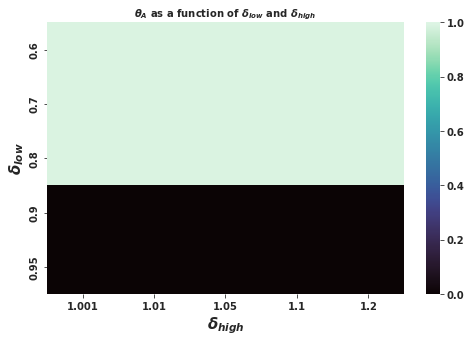

         1.001     1.010     1.050     1.100     1.200
0.60  0.189977  0.183261  0.153528  0.131205  0.131205
0.70  0.204700  0.204700  0.204700  0.204700  0.204700
0.80  0.266868  0.266868  0.266868  0.266868  0.266868
0.90  0.000000  0.000000  0.000000  0.000000  0.000000
0.95  0.000000  0.000000  0.000000  0.000000  0.000000


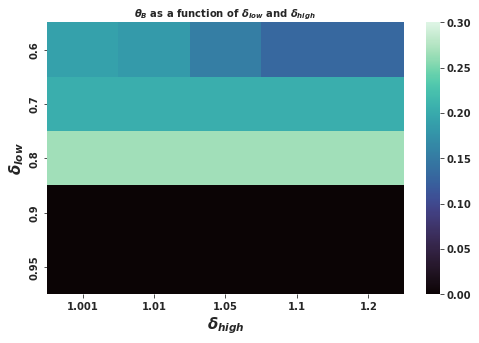

In [15]:
ser = pd.Series(list(theta_A.values()), index = pd.MultiIndex.from_tuples(theta_A.keys()))
df = ser.unstack().fillna(0)

print(df)
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.heatmap(df,cmap='mako', vmin=0., vmax=1)
plt.title("$\\theta_A$ as a function of $\\delta_{low}$ and $\\delta_{high}$")
plt.xlabel("$\\delta_{high}$")
plt.ylabel("$\\delta_{low}$")
plt.savefig(dire+ dataset_name+"_heatmap_theta_A_ratio_params.pdf")
plt.show()


ser = pd.Series(list(theta_B.values()),
                  index=pd.MultiIndex.from_tuples(theta_B.keys()))
df = ser.unstack().fillna(0)
print(df)

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.heatmap(df,cmap='mako', vmin=0, vmax=0.3)
plt.title("$\\theta_B$ as a function of $\\delta_{low}$ and $\\delta_{high}$")
plt.xlabel("$\\delta_{high}$")
plt.ylabel("$\\delta_{low}$")
plt.savefig(dire+dataset_name+"_heatmap_theta_B_ratio_params.pdf")
plt.show()

### heatmap varying homophily constraint

In [23]:
add_epsilon = 0.0       
delta_low = 0.25
delta_high = 2.
share_list = []
ig_share_list = [] #intergroup shares
st = 0.1
n = np.arange(0.5, 1.01, step=st).shape[0]
data = np.zeros(n)
ig_data = np.zeros(n)
for k,q_A in enumerate(np.arange(0.5, 1.01, step=st)):
    q = {-1: q_A, 1: 0.75}
    theta_fair = platform_opt.opt('ratio',pi, q, T, c,v,beta_dist,delta_low = delta_low, \
                                  delta_high=delta_high, exposure_e=0.0)
    print(k)
    for i in range(num_trials):
        players_in_model_fair, shown_d_fair, click_d_fair, share_d_fair = sims.runModel(theta_fair,\
                                  T, pi, M, P, beta_dist, v,c,q)
        share_list.append(sum([share_d_fair[key] for key in share_d_fair.keys()]))
        ig_share_list.append(sum([share_d_fair[key] for key in share_d_fair.keys() if key[0] == -key[1]]))


    data[k] = np.mean(share_list)
    ig_data[k] = np.mean(ig_share_list)

df = pd.DataFrame({"Total Shares": data, "Intergroup Shares": ig_data, "$q_A$" : np.round(np.arange(0.5,\
                                                                    1.01, step=st), 2)})

0
1
2
3
4
5


In [24]:
sims.saveRuns(df, dire_data+ dataset_name+'_homophily_shares_fix_qB.pkl')

In [25]:
df = sims.loadRuns(dire_data+dataset_name+'_homophily_shares_fix_qB.pkl')

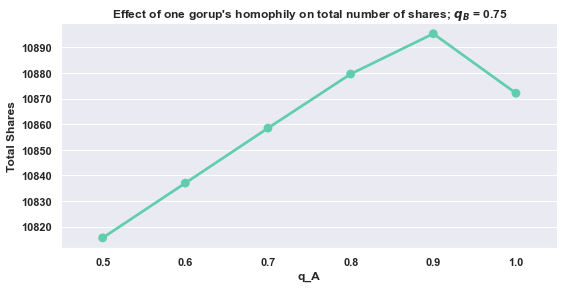

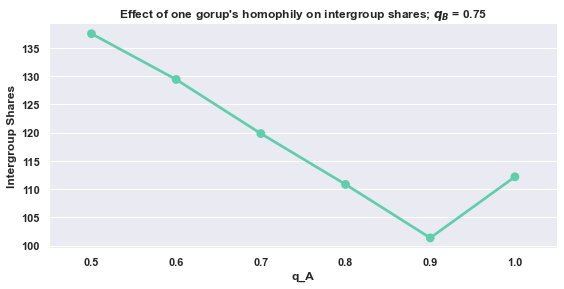

In [28]:
ax = sns.factorplot(data = df, x = "$q_A$", y = "Total Shares", log=True, color=mk[3],\
                   size=4, aspect=2)
plt.title("Effect of one gorup's homophily on total number of shares; $q_B$ = 0.75")
plt.xlabel("q_A")
plt.savefig(dire+"_homophily_shares_fix_qB.pdf")
plt.show()

ax = sns.factorplot(data = df, x = "$q_A$", y = "Intergroup Shares", log=True, color=mk[3], \
                   size=4, aspect=2)
plt.title("Effect of one gorup's homophily on intergroup shares; $q_B$ = 0.75")
plt.xlabel("q_A")
plt.savefig(dire+dataset_name+"_homophily_ig_shares_fix_qB.pdf")
plt.show()


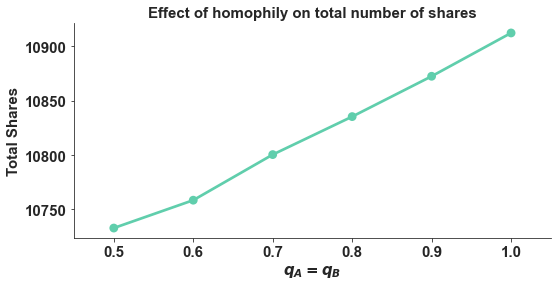

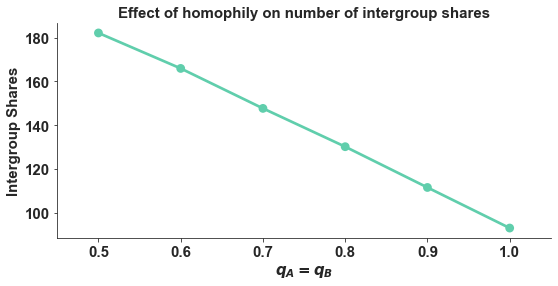

In [5]:
ax = sns.factorplot(data = df, x = "$q_A = q_B$", y = "Total Shares", log=True, color=mk[3],\
                   size=4, aspect=2)
plt.title("Effect of homophily on total number of shares")
plt.savefig(dire+dataset_name+"_homophily_shares.pdf")
plt.show()

ax = sns.factorplot(data = df, x = "$q_A = q_B$", y = "Intergroup Shares", log=True, color=mk[3], \
                   size=4, aspect=2)
plt.title("Effect of homophily on number of intergroup shares")
plt.savefig(dire+dataset_name+"_homophily_ig_shares.pdf")
plt.show()


In [13]:
share_list = []
ig_share_list = [] #intergroup shares

st = 500
rng_min = 1000
rng_max = 2501
T = 3
epsilon = 0.0 
n = np.arange(rng_min, rng_max, step=st).shape[0]
data_psi = np.zeros((n,n))
ig_data_psi = np.zeros((n,n))


for k,intra in enumerate(np.arange(rng_min, rng_max, step=st)):
    for j,inter in enumerate(np.arange(rng_min, rng_max, step=st)):
        if k <= j:
            print((j,k))
            v = {(1,1): intra, (-1,1): inter, (1,-1): inter, (-1,-1):intra }
            theta_fair = platform_opt.opt('ratio',pi, q, T, c,v,beta_dist,\
                                          delta_low = delta_low, delta_high=delta_high, exposure_e=0.05)
            for i in range(num_trials):
                players_in_model_fair, shown_d_fair, click_d_fair, share_d_fair = sims.runModel(theta_fair,\
                                                                        T, pi, M, P, beta_dist, v,c,q)
                share_list.append(sum([share_d_fair[key] for key in \
                                       share_d_fair.keys()]))
                ig_share_list.append(sum([share_d_fair[key] for key in share_d_fair.keys() if key[0] ==\
                                          -key[1]]))
                     
            data_psi[j,k] = np.mean(share_list)
            ig_data_psi[j,k] = np.mean(ig_share_list)
                      


(0, 0)
(1, 0)
(2, 0)
(3, 0)
(1, 1)
(2, 1)
(3, 1)
(2, 2)
(3, 2)
(3, 3)


In [14]:
sims.saveRuns(data_psi, dire_data+'_heatmap_psi.pkl')
sims.saveRuns(ig_data_psi, dire_data+'_heatmap_psi_intergroup.pkl')

In [15]:
data_psi = sims.loadRuns(dire_data+dataset_name+'_heatmap_psi.pkl')
ig_data_psi = sims.loadRuns(dire_data+dataset_name+'_heatmap_psi_intergroup.pkl')

In [18]:
print(data_psi)

[[10473.48           0.             0.             0.        ]
 [10483.12       10492.336          0.             0.        ]
 [10486.48       10495.05333333 10497.46           0.        ]
 [10490.08       10493.89142857 10496.35555556 10498.628     ]]


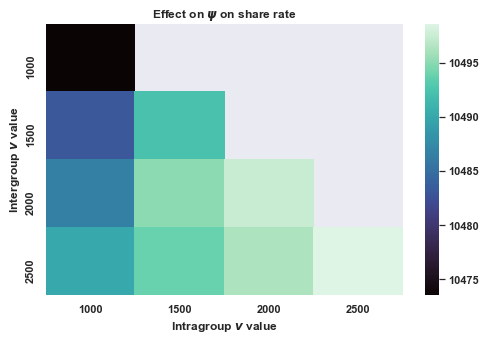

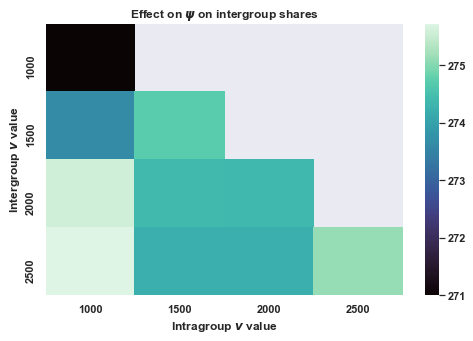

In [22]:
sns.set()
fig, ax = plt.subplots(figsize=(8, 5))

mask = np.zeros_like(data_psi)
mask[np.triu_indices_from(mask,k=1)] = True
ax = sns.heatmap(data_psi,cmap='mako', mask=mask, xticklabels=[np.round(x,2) for x in\
        np.arange(rng_min, rng_max, step=st)], yticklabels = [np.round(x,2) for x in\
                                                              np.arange(rng_min, rng_max, step=st)])
plt.title("Effect on $\\psi$ on share rate")
plt.ylabel("Intergroup $v$ value")
plt.xlabel("Intragroup $v$ value")
plt.savefig(dire+dataset_name+"_heatmap_psi.pdf")
plt.show()



fig, ax = plt.subplots(figsize=(8, 5))
mask = np.zeros_like(ig_data_psi)
mask[np.triu_indices_from(mask,k=1)] = True
ax = sns.heatmap(ig_data_psi,cmap="mako", mask=mask, xticklabels=[np.round(x,2) for x in\
        np.arange(rng_min, rng_max, step=st)], yticklabels=[np.round(x,2) for x in\
                                                            np.arange(rng_min, rng_max, step=st)])
plt.title("Effect on $\\psi$ on intergroup shares")
plt.ylabel("Intergroup $v$ value")
plt.xlabel("Intragroup $v$ value")
plt.savefig(dire+dataset_name+"_heatmap_psi_intergroup.pdf")
plt.show()
